## Imports

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as T
import bcolz
import time
from torch.utils.data import Dataset, DataLoader, sampler
%matplotlib inline

In [2]:
use_gpu = torch.cuda.is_available()
print('Using gpu: %s ' % use_gpu)

def gpu(x,use_gpu=use_gpu):
    if use_gpu:
        return x.cuda()
    else:
        return x

Using gpu: True 


## Data processing

In [3]:
data_dir = './Dataset'

transform = T.Compose([
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dsets = {x: dset.ImageFolder(os.path.join(data_dir, x), transform=transform)
         for x in ['train', 'val', 'test']}

train_dataset = dset.ImageFolder('./Dataset/train', transform=transform)
val_dataset = dset.ImageFolder('./Dataset/val', transform=transform)
test_dataset = dset.ImageFolder('./Dataset/test', transform=transform)

In [4]:
train_size = len(train_dataset)
val_size = len(val_dataset)
test_size = len(test_dataset)
print("Number of training examples {}, validation examples {}, testing examples {}".format(train_size, val_size, test_size))

Number of training examples 66071, validation examples 11016, testing examples 33154


In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=6)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=6)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Creating Model

In [6]:
channel_1 = 64
channel_2 = 64
channel_3 = 32
channel_4 = 16

fc_hidden_size= 1000

model = nn.Sequential(
    nn.Conv2d(3, channel_1, 3, padding=1, bias=True),
    nn.BatchNorm2d(channel_1),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(channel_1, channel_2, 3, padding=1, bias=True),
    nn.BatchNorm2d(channel_2),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(channel_2, channel_3, 3, padding=1, bias=True),
    nn.BatchNorm2d(channel_3),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Conv2d(channel_3, channel_4, 3, padding=1, bias=True),
    nn.BatchNorm2d(channel_4),
    nn.ReLU(),
    nn.MaxPool2d(2, stride=2),
    nn.Flatten(),
    nn.Linear(channel_4*14*14, 172, bias=True),
)

## Training fully connected module

### Loading Preconvoluted features

In [7]:
optimizer = optim.Adam(model.parameters())

### Training the model

In [8]:
def train_model(model, optimizer, train_dataset, val_dataset, epochs=1):
    train_loss_history = []
    train_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []
    for epoch in range(epochs):
        model.train()
        num_correct, num_samples, total_loss = 0, 0, 0
        running_corrects = 0
        for x, y in train_dataset:
            x, y = gpu(x), gpu(y)
            scores = model(x)
            loss = F.cross_entropy(scores, y)           
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(scores.data,1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
        train_loss_history.append(average_loss)
        train_accuracy_history.append(acc)
        print('Epoch: {} Training Loss: {:.4f} Got {} / {} correct. Acc: {:.2f}%'.format(
                     epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        
        check_accuracy(model, val_dataset, val_loss_history, val_accuracy_history, epoch)
    return train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history

def check_accuracy(model, dataset, val_loss_history, val_accuracy_history, epoch):
    num_correct, num_samples, total_loss = 0, 0, 0
    model.eval()
    with torch.no_grad():
        for x, y in dataset:
            x, y = gpu(x), gpu(y)
            scores = model(x)
            loss = F.cross_entropy(scores, y) 
            _, preds = torch.max(scores.data, 1)
            total_loss += loss.data.item()
            num_correct += torch.sum(preds == y.data)
            num_samples += preds.size(0)
        average_loss = total_loss / num_samples
        acc = num_correct / num_samples
    val_loss_history.append(average_loss)
    val_accuracy_history.append(acc)
    print('Epoch: {} Validation Loss: {:.4f} Got {} / {} correct {:.2f}%'.format(
        epoch + 1, average_loss, num_correct, num_samples, 100 * acc))
        

In [9]:
%%time
LOSS, ACC, LOSS_V, ACC_V = train_model(gpu(model), optimizer, train_dataloader, val_dataloader, epochs=10)

Epoch: 1 Training Loss: 0.0613 Got 9272 / 66071 correct. Acc: 14.03%
Epoch: 1 Validation Loss: 0.0522 Got 2505 / 11016 correct 22.74%
Epoch: 2 Training Loss: 0.0463 Got 19747 / 66071 correct. Acc: 29.89%
Epoch: 2 Validation Loss: 0.0469 Got 3264 / 11016 correct 29.63%
Epoch: 3 Training Loss: 0.0368 Got 27945 / 66071 correct. Acc: 42.30%
Epoch: 3 Validation Loss: 0.0457 Got 3532 / 11016 correct 32.06%
Epoch: 4 Training Loss: 0.0294 Got 34761 / 66071 correct. Acc: 52.61%
Epoch: 4 Validation Loss: 0.0457 Got 3687 / 11016 correct 33.47%
Epoch: 5 Training Loss: 0.0234 Got 40488 / 66071 correct. Acc: 61.28%
Epoch: 5 Validation Loss: 0.0484 Got 3609 / 11016 correct 32.76%
Epoch: 6 Training Loss: 0.0187 Got 45178 / 66071 correct. Acc: 68.38%
Epoch: 6 Validation Loss: 0.0535 Got 3461 / 11016 correct 31.42%
Epoch: 7 Training Loss: 0.0149 Got 48948 / 66071 correct. Acc: 74.08%
Epoch: 7 Validation Loss: 0.0591 Got 3239 / 11016 correct 29.40%
Epoch: 8 Training Loss: 0.0120 Got 52220 / 66071 correct

In [21]:
torch.save(model.state_dict(), './baseline.pt')
torch.save({'loss': LOSS, 'acc': ACC, 'loss_v': LOSS_V, 'acc_v': ACC_V}, './baseline-history.pt')

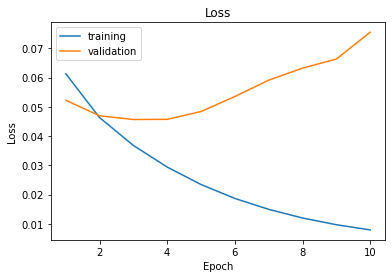

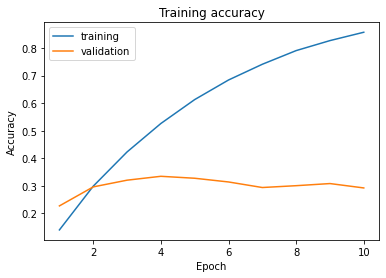

In [22]:
plt.figure()
E = np.arange(10)+1
plt.plot(E,LOSS,label='training')
plt.plot(E,LOSS_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(E,ACC,label='training')
plt.plot(E,ACC_V,label='validation')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training accuracy")
plt.legend()
plt.show()

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images = gpu(images)
        labels = gpu(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the all test images: %d %%' % (
    100 * correct / total))

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the all test images: 28 %
